# Getting Started with ICESAT-2 ATL08 subset data

This tutorial shows how to get started with ICESAT-2/ATLAS L3A Land and Vegetation Height ([ATL08](https://doi.org/10.5067/ATLAS/ATL08.006)) subsets from the [Global Subset Tool](https://modis.ornl.gov/globalsubset/). Please refer to the data [user guide](https://nsidc.org/sites/default/files/documents/user-guide/atl08-v006-userguide.pdf) and the [ATBD](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl08_atbd_v006_0.pdf) for more information about the data product. 

Let's first import the required Python modules. This tutorial requires the following Python modules installed in your system: `requests`, `numpy`, `h5py`, `geopandas`, `pandas`, `contextily` and `matplotlib`. Requirements are also in `requirements.txt` within this repo. To install the necessary Python modules, you can copy the requirements.txt from this repository and run:
```bash
pip install -r requirements.txt
```

In [1]:
import requests
import tarfile
import glob
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from os import path

### Place Global Subsets Order
Let's submit [Global Subset requests](https://modis.ornl.gov/globalsubset/) for ICESAT-2/ATLAS L3A Land and Vegetation Height ([ATL08](https://doi.org/10.5067/ATLAS/ATL08.006)) for an area near [Lopé National Park](https://en.wikipedia.org/wiki/Lop%C3%A9_National_Park) (Latitude: `0.26918S`, Longitude: `11.6573E`) in Gabon. We will request a subset area of about 20km x 20km. 

It will take some time to finish processing the subset orders, and once the subsets are ready, you will receive an email with the link to the order delivery pages like the following: https://modis.ornl.gov/subsetdata/11Jul2023_15:43:08_297894233L-0.26918L11.6573S21L21_ATL08_1

### Download Files
Let's download the HDF5 files from the order delivery pages and save it to the folder here. The `HDF5.tar.gz` file contains the compressed version of these files.

In [2]:
# function to download and untar file file
def download_tar(orderid):
    order_url = 'https://modis.ornl.gov/subsetdata' # order URL
    h5_tar = 'HDF5.tar.gz' # tar file name
    
    # get requests
    r = requests.get(f'{order_url}/{orderid}/h5/{h5_tar}', stream=True)
    r.raise_for_status()
    
    # download tar file
    with open(f'output/{h5_tar}', 'wb') as f:
        f.write(r.raw.read())
    
    # extract tar file
    with tarfile.open(f'output/{h5_tar}') as f:
        f.extractall('output') 

# order id from the Global Subsets Tool
orderid = '11Jul2023_15:43:08_297894233L-0.26918L11.6573S21L21_ATL08_1'

# download and uncompress ATL08 files
download_tar(orderid)

Now that the files are downloaded to the `output` folder let's print all the ATL08 subset files.

In [13]:
atl08_f = sorted(glob.glob("output/ATL08*"))
atl08_f

['output/ATL08_20191011093003_02210508_006_02.h5',
 'output/ATL08_20191125191300_09140514_006_01.h5',
 'output/ATL08_20200126161644_04720614_006_01.h5',
 'output/ATL08_20220607111220_11661508_006_01.h5',
 'output/ATL08_20220906065216_11661608_006_01.h5',
 'output/ATL08_20221021163507_04721714_006_01.h5',
 'output/ATL08_20230218105058_09141814_006_01.h5']

Seven ATL08 files that are within the subset area.

### Land Segments
ATL08 data are grouped into six ground tracks: `gt1l`, `gt1r`, `gt2l`, `gt2r`, `gt3l`, and `gt3r`. The ground tracks with names ending with `l` are strong beams, and those ending with `r` are weak beam types. The `land_segments` group within each ground track contains photon data stored as aggregates of 100 meters. 

Within the `land_segments` group, the geolocation coordinates are provided in `latitude` and `longitude` variables. The variable `n_seg_ph` contains the number of photons in each segment. Let's read those variables from the subset files and put them into a geopandas dataframe.

In [4]:
latitude = []
longitude = []
n_seg_ph = []

for h5_f in atl08_f:
     with h5py.File(h5_f) as hf:
        for var in list(hf.keys()):
            if var.startswith('gt'):
                latitude.extend(hf[var]['land_segments']['latitude'][:])
                longitude.extend(hf[var]['land_segments']['longitude'][:])
                n_seg_ph.extend(hf[var]['land_segments']['n_seg_ph'][:])

# read the lists into a dataframe
s_df = pd.DataFrame(list(zip(latitude,longitude,n_seg_ph)), columns=["latitude", "longitude", "n_seg_ph"])
# converting pandas dataframe into geopandas dataframe
s_gdf = gpd.GeoDataFrame(s_df, geometry=gpd.points_from_xy(s_df.longitude, s_df.latitude))
s_gdf.crs = "EPSG:4326" # WGS84 CRS
# print the first two rows
s_gdf.head(2)

,latitude,longitude,n_seg_ph,geometry
0,-0.237363,11.678988,120,POINT (11.67899 -0.23736)
1,-0.238265,11.678891,96,POINT (11.67889 -0.23826)


Let's plot the land segments' location over a base map. First, we will convert to geopandas dataframe (`s_gdf`) into Web Mercator (EPSG 3857) to bring it to the same coordinate reference system as the base map.

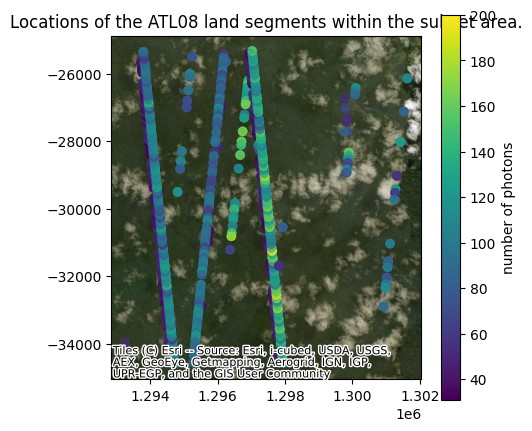

In [5]:
s_3857_gdf = s_gdf.to_crs(epsg=3857)
ax = s_3857_gdf.plot(alpha=0.7,  column='n_seg_ph', cmap='viridis', legend=True, 
                     legend_kwds={'label': "number of photons"}, figsize=(5, 5))
ax.set(title='Locations of the ATL08 land segments within the subset area.')
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
plt.show()

As you can see in the figure above, the number of photons varies from one land segment to the other, ranging from 51 to 189 for the subset area.

### Canopy height metrics
Canopy height metrics for each land segment are provided within the `canopy` subgroup. The metrics give the cumulative distribution of relative canopy heights above the interpolated ground surface (`canopy_h_metrics`) and absolute heights above the WGS84 ellipsoid (`canopy_h_metrics_abs`) at the following percentiles: 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95.

Let's retrieve the relative canopy height metrics of one of the subset files (`ATL08_20220607111220_11661508_006_01.h5`) and its track (`gt3l`). We will then compute the distance of each land segment from the first one for plotting.

In [19]:
first_h5 = atl08_f[3] # ATL08_20220607111220_11661508_006_01.h5
track = 'gt3l'

# reading the h5 file
with h5py.File(first_h5) as hf:
    # time
    delta_time = hf[track]['land_segments']['delta_time'][:]
    # canopy height metrics
    v = hf[track]['land_segments']['canopy']['canopy_h_metrics']
    fill_value_chm = v.attrs['_FillValue'] # fill value
    chm = v[:]

# set fill value to NaNs
chm[chm==fill_value_chm] = np.nan

# create pandas dataframe
chm_df = pd.DataFrame(data = chm, columns = list(range(100))[10::5])
# insert lat/lon
chm_df.loc[:, 'delta_time'] = delta_time

# print the first two rowsdataframe
chm_df.head(2)

,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,delta_time
0,24.883148,31.850281,37.120697,44.613556,51.936035,55.361420,57.207031,58.420471,59.449036,63.533203,64.162903,64.545990,66.149109,67.266235,67.840729,70.177399,74.026093,85.125854,1.398355e+08
1,29.354034,30.452087,31.641907,32.892487,33.426514,35.312347,35.883850,36.959167,38.025543,38.631439,39.569855,40.097198,41.246735,41.651611,43.252045,44.309326,46.842987,51.501678,1.398355e+08


Now, let's plot the canopy height metrics of the land segments.

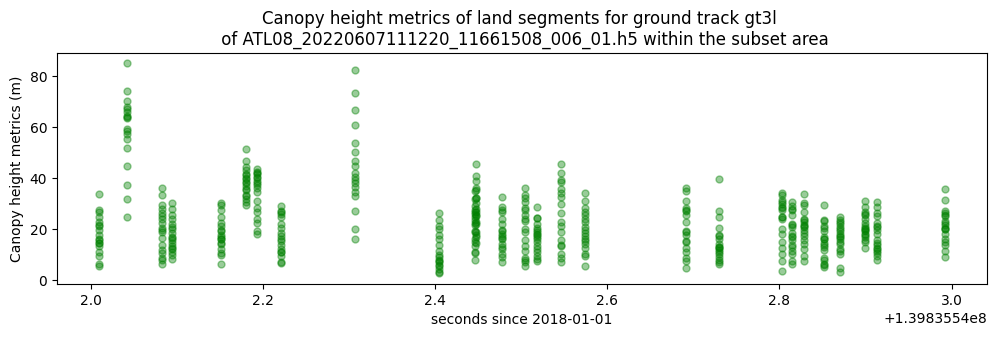

In [20]:
title=f'Canopy height metrics of land segments for ground track {track} \n of {path.basename(first_h5)} within the subset area'
ax = chm_df.plot(kind='line', x='delta_time', y=chm_df.columns[:18], title=title, 
                          marker='.', linestyle='none', c='g', ms=10, alpha=0.4, legend=False, figsize=(12,3))
ax.set_xlabel("seconds since 2018-01-01")
ax.set_ylabel("Canopy height metrics (m)")
plt.show()

### Canopy/Terrain heights for geosegments
ATL08 also provides selected canopy and terrain variables for 20m geosegments (`h_canopy_20m`, `h_te_best_fit_20m`, `latitude_20m`, `longitude_20m`). There are five geosegments within a land segment. 

### Photon classification
Photon information is provided in the `signal_photons` group within each ground track. Let's plot the photon height (`ph_h`) and classification (`classed_pc_flag`) of these four ATL08 files.

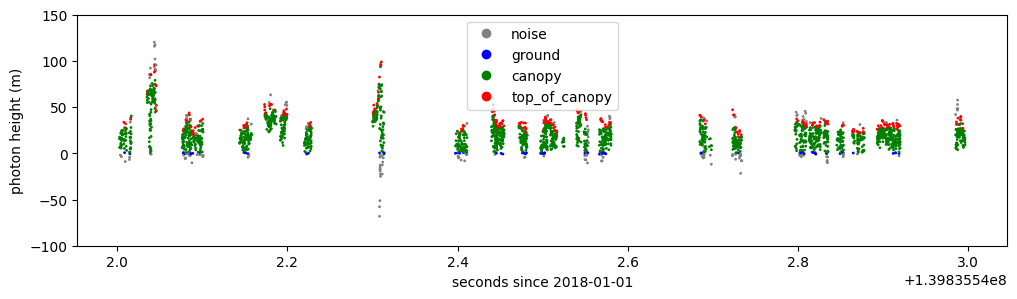

In [22]:
first_h5 = atl08_f[3] # ATL08_20220607111220_11661508_006_01.h5
track = 'gt3l'

with h5py.File(first_h5) as hf:
    ph_h= hf[track]['signal_photons']['ph_h'][:]
    classed_pc_flag = hf[track]['signal_photons']['classed_pc_flag'][:]
    delta_time = hf[track]['signal_photons']['delta_time'][:] 
    
# photon classes
classes = ['noise', 'ground', 'canopy', 'top_of_canopy']   
colors = ListedColormap(['gray','blue','green','red'])
plt.figure(figsize=(12, 3))
scatter = plt.scatter(delta_time,ph_h,c=classed_pc_flag, cmap=colors, s=1)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.ylim(-100, 150) 
plt.xlabel("seconds since 2018-01-01")
plt.ylabel("photon height (m)")
plt.show()

The Global Subset tools also provide subset data in a `GeoJSON` format which can be used to import the ICESAT-2 ATL08 data into GIS software directly.